In [33]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [34]:
import numpy as np
import pandas as pd

In [35]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [36]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [37]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [38]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [39]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [40]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [41]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [166]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_date = session.query(Measurement.date).group_by(Measurement.prcp).order_by(Measurement.date.desc()).all()[0]
last_date


('2017-08-23')

In [167]:
# Calculate the date 1 year ago from today

year_ago = dt.datetime.today() - dt.timedelta(days=365)
year_ago


datetime.datetime(2018, 2, 9, 22, 10, 39, 523058)

In [133]:
# Perform a query to retrieve the data and precipitation scores

precip_data = session.query(Measurement.date, func.avg(Measurement.prcp)).\
    filter(Measurement.date > '2016-08-23').group_by(Measurement.date).\
    order_by(Measurement.date.asc()).all()


<IPython.core.display.Javascript object>


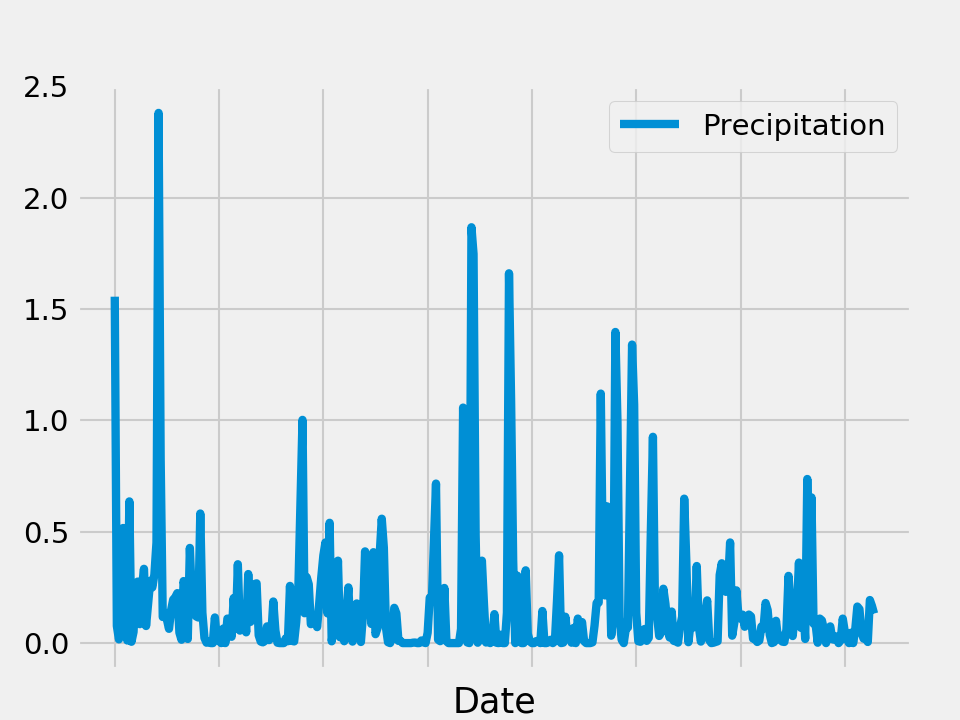

In [102]:
# Save the query results as a Pandas DataFrame and set the index to the date column

dates_tup, precip_tup = zip(*precip_data)

precip_df = pd.DataFrame({'Date':dates_tup, 'Precipitation':precip_tup})
precip_df['Precipitation'] = precip_df['Precipitation'].fillna(value=0.0)

precip_df.index = precip_df['Date']

precip_df.plot('Date', 'Precipitation', kind='line')


In [92]:
# Sort the dataframe by date

precip_df = precip_df.sort_index(ascending=True)
precip_df.head()


,Date,Precipitation
Date,,
2016-08-24,2016-08-24,1.555000
2016-08-25,2016-08-25,0.077143
2016-08-26,2016-08-26,0.016667
2016-08-27,2016-08-27,0.064000
2016-08-28,2016-08-28,0.516667


<IPython.core.display.Javascript object>


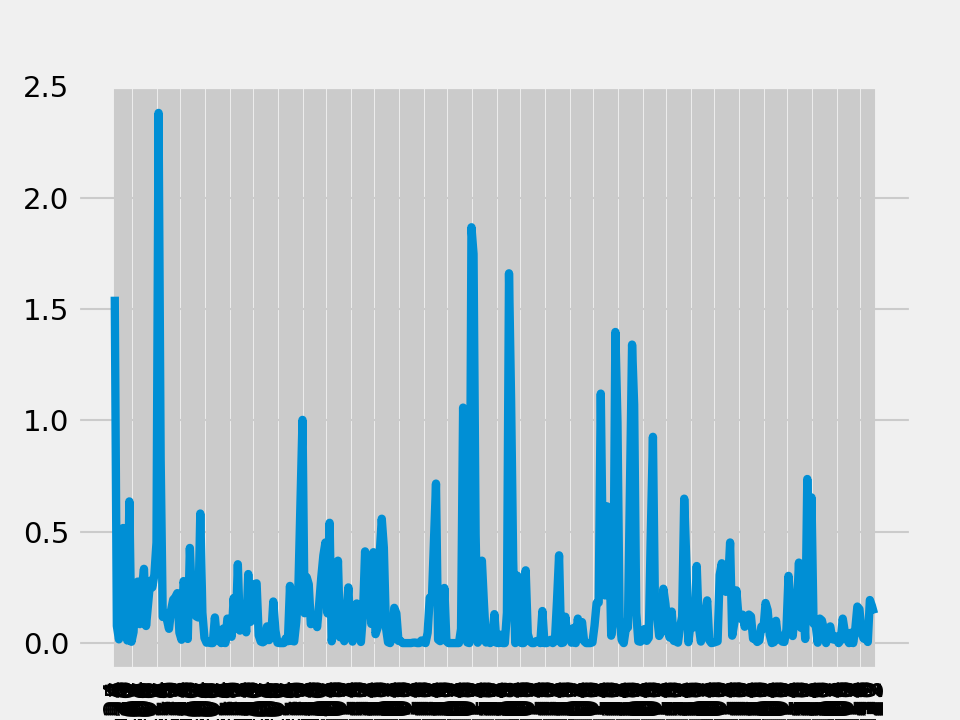

In [103]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.subplots()
plt.plot(precip_df['Date'], precip_df['Precipitation'])
plt.show()


In [104]:
# Rotate the xticks for the dates

plt.xticks(precip_df['Date'], rotation = 'vertical')
plt.show()


In [56]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_df.describe()


,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [58]:
# How many stations are available in this dataset?

session.query(func.count(Station.id)).all()


[(9)]

In [130]:
# What are the most active stations?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [132]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

In [61]:
session.query(Measurement.date).filter(Measurement.station=="USC00519281").order_by(Measurement.date.desc()).all()[0]

('2017-08-18')

<IPython.core.display.Javascript object>


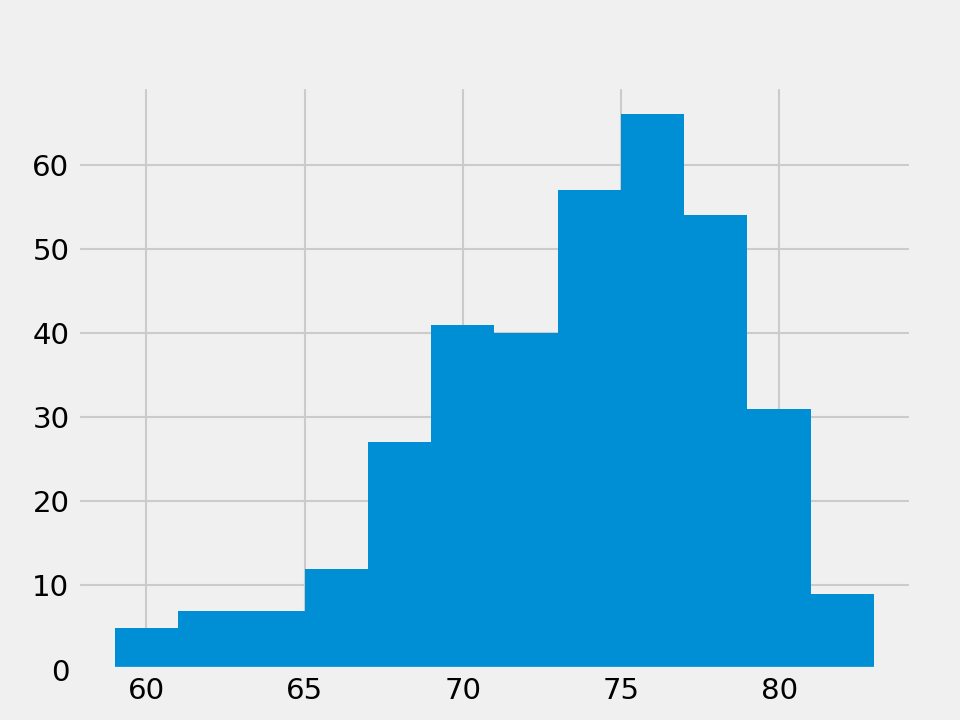

(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 54., 31.,  9.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

In [150]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date>'2016-08-18').\
    filter(Measurement.station=='USC00519281').order_by(Measurement.date.asc()).all()
dates_tup, temp_tup = zip(*temp_data)

plt.subplots()
temp_df = pd.DataFrame({'Date':list(dates_tup), 'Temperature':list(temp_tup)})
plt.hist(temp_df['Temperature'], bins=12)


In [63]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [67]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2017-04-26','2017-04-29'))


[(66.0, 74.07692307692308, 81.0)]


<IPython.core.display.Javascript object>


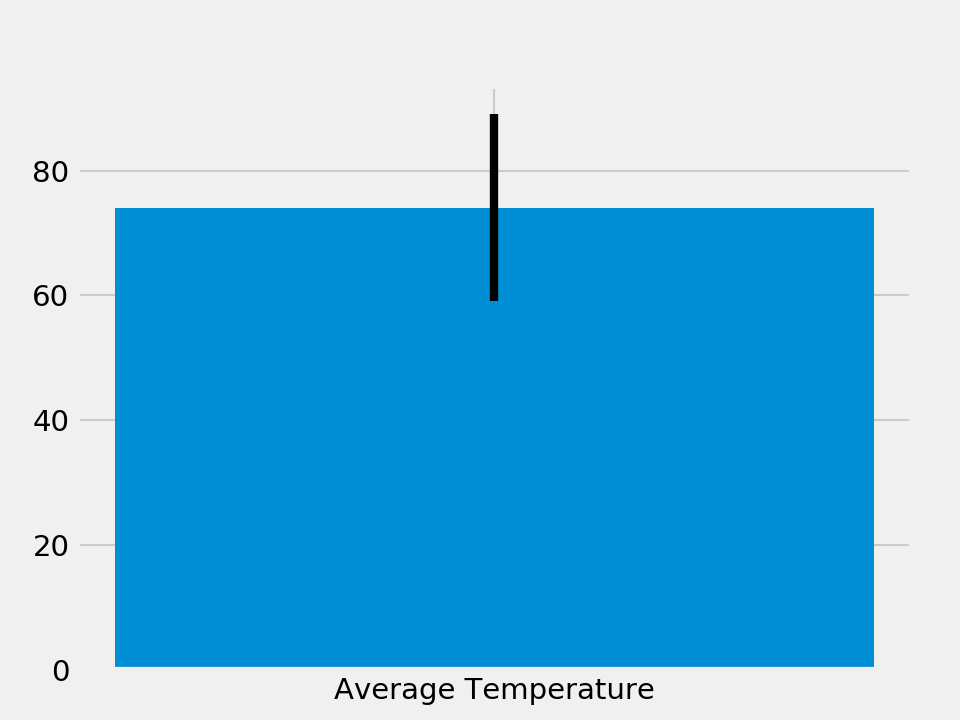

In [151]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin = calc_temps('2017-04-26','2017-04-29')[0][0]
tavg = calc_temps('2017-04-26','2017-04-29')[0][1]
tmax = calc_temps('2017-04-26','2017-04-29')[0][2]

plt.subplots()
plt.bar([0], tavg, width= 0.5, tick_label = 'Average Temperature', yerr=tmax-tmin)
plt.show()


In [140]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_data = session.query(Station.station, Station.name, Station.latitude, Station.longitude, func.sum(Measurement.prcp)).\
    filter( Measurement.station == Station.station).filter('2017-04-26'<= Measurement.date).\
    filter(Measurement.date <='2017-04-29').group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

station_tup, name_tup, latitude_tup, longitude_tup, total_rain_tup = zip(*trip_data)

trip_df = pd.DataFrame({'Station':list(station_tup), 'Name':list(name_tup),\
                       'Latitude':list(latitude_tup), 'Longitude':list(longitude_tup),
                       'Total Rainfall During Trip':list(total_rain_tup)})

trip_df


,Station,Name,Latitude,Longitude,Total Rainfall During Trip
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,6.26
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,3.05
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,1.34
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,1.20
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,1.12
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,0.12
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,NaN
